In [1]:
import pandas as pd
import numpy as np

from scipy import stats as sc_stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2023-05-05 05:15:42.504343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import sys
from os.path import dirname
sys.path.append(dirname("../"))

In [4]:
from src.edl import dense_layers,dense_loss
from src.weibull_edl import loss_and_layers

In [5]:
%load_ext autoreload
%autoreload 2

### Read data

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_27747/4184444109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean1["recovery_rate_ad"] = np.where(df_clean1["recovery_rate"]<=1.2,df_clean1["recovery_rate"],1.2)


(1.2448616350251744, -0.13071235094229539, 11.687405405366217)


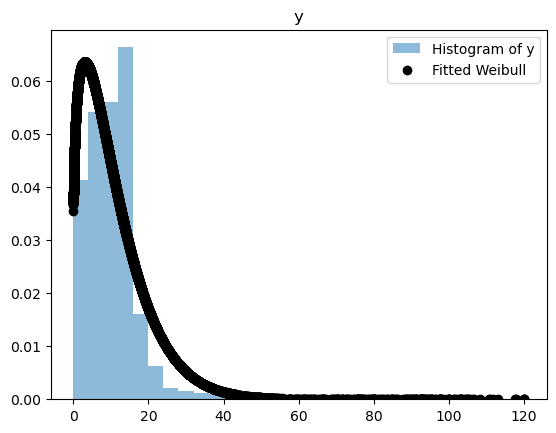

In [6]:
df_clean = pd.read_csv("../data/data_preprocessed_v0.csv",index_col=0)
df_clean["ccf_ad"] = (1.0-df_clean["CCF"])*100
df_clean1 = df_clean[df_clean.recovery_rate>0.0]
df_clean1["recovery_rate_ad"] = np.where(df_clean1["recovery_rate"]<=1.2,df_clean1["recovery_rate"],1.2)
# df_clean.head()

y_cols = ["recovery_rate","CCF"]

X = df_clean1.drop(columns=y_cols + list(df_clean1.columns)[35:39])
y = df_clean1["recovery_rate_ad"] * 100.0

rv = sc_stats.weibull_min.fit(y)
print (rv)
plt.hist(y,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y, sc_stats.weibull_min.pdf(y,*rv),label="Fitted Weibull",color="black")
plt.title("y")
plt.legend()

In [7]:
y=y-(-0.13071235094229539)
print(X.shape,y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

(23300, 45) (23300,)


((18640, 45), (4660, 45), (18640,), (4660,))

(1.2386219353578642, 0.006961386029716193, 11.648641022695987)


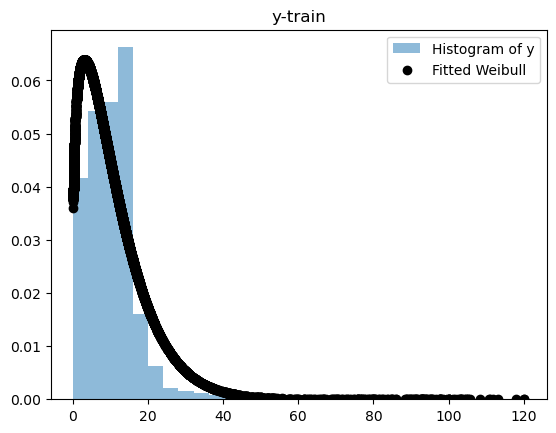

In [8]:
rv = sc_stats.weibull_min.fit(y_train)
print (rv)
plt.hist(y_train,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y_train, sc_stats.weibull_min.pdf(y_train,*rv),label="Fitted Weibull",color="black")
plt.title("y-train")
plt.legend()

Text(0.5, 1.0, 'Distribution of y')

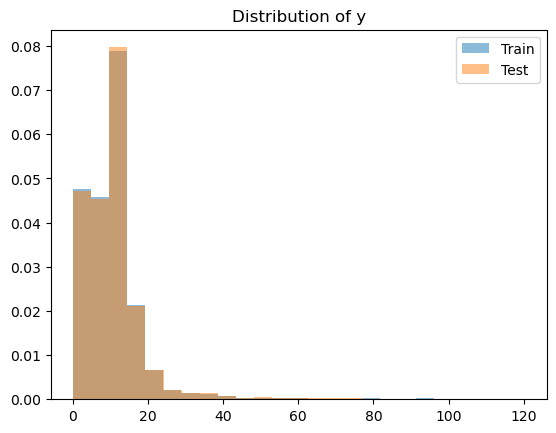

In [9]:
plt.hist(y_train,density=True,alpha=0.5,label="Train",bins=25)
plt.hist(y_test,density=True,alpha=0.5,label="Test",bins=25)
plt.legend()
plt.title("Distribution of y")

### Benchmark Model

In [27]:
def results_normal_model(c):
    edl_model2 = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(64, activation="softmax"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(20, activation="relu"),
        dense_layers.DenseNormalGamma(1),
    ])
    
    def EvidentialRegressionLoss(true, pred):
        return dense_loss.EvidentialRegression(true, pred, coeff=c)
    
    # Compile and fit the model!
    edl_model2.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=EvidentialRegressionLoss)

    edl_model2.fit(x_train, y_train, batch_size=100, epochs=350, verbose = 0)
    y_pred = edl_model2.predict(x_test)
    return y_pred,edl_model2

In [52]:
results_normal = {}
for c_i in np.linspace(1e-3,1e-1,10):
    results_normal[c_i] = results_normal_model(c_i)
    print (f"For c={c_i}, MSE = {mean_squared_error(y_test,results_normal[c_i][0][:,0])}")

146/146 [==============================] - 0s 671us/step
For c=0.001, MSE = 91.58430022783485
146/146 [==============================] - 0s 673us/step
For c=0.012, MSE = 4.159230316945297
146/146 [==============================] - 0s 668us/step
For c=0.023000000000000003, MSE = 90.61890693787927
146/146 [==============================] - 0s 834us/step
For c=0.034, MSE = 91.06032751728513
146/146 [==============================] - 0s 679us/step
For c=0.045000000000000005, MSE = 19.31145223869325
146/146 [==============================] - 0s 763us/step
For c=0.05600000000000001, MSE = 0.11917386723314691
146/146 [==============================] - 0s 1ms/step
For c=0.067, MSE = 90.91383640430746
146/146 [==============================] - 0s 831us/step
For c=0.07800000000000001, MSE = 0.29974701632507056
146/146 [==============================] - 0s 840us/step
For c=0.08900000000000001, MSE = 0.09704852899564662
146/146 [==============================] - 0s 917us/step


ValueError: Input contains NaN.

In [119]:
edl_model2 = results_normal[0.045000000000000005][1]
edl_model2.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 1)                 46        
                                                                 
 dense_211 (Dense)           (None, 100)               200       
                                                                 
 dense_212 (Dense)           (None, 64)                6464      
                                                                 
 dense_213 (Dense)           (None, 32)                2080      
                                                                 
 dense_214 (Dense)           (None, 20)                660       
                                                                 
 dense_normal_gamma_35 (Dens  (None, 4)                84        
 eNormalGamma)                                                   
                                                     

In [120]:
y_pred = edl_model2.predict(x_train)
mu, v, alpha, beta = y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3]
var = np.sqrt(beta / (v * (alpha - 1)))
mean_squared_error(y_train,y_pred[:,0]),var.mean()

583/583 [==============================] - 1s 848us/step


/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_27747/1580600152.py:3: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


(22.33449106537266, inf)

In [124]:
y_pred = edl_model2.predict(x_test)
mu, v, alpha, beta = y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3]
var = np.sqrt(beta / (v * (alpha - 1)))
mean_squared_error(y_test,y_pred[:,0]),var.mean()

146/146 [==============================] - 0s 866us/step


/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_27747/3389752287.py:3: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


(19.31145223869325, inf)

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_27747/1482430385.py:3: RuntimeWarning: divide by zero encountered in divide
  var = np.sqrt(beta / (v * (alpha - 1)))


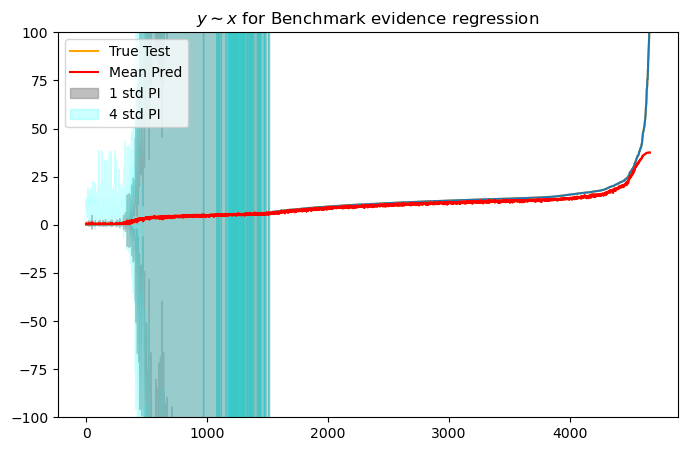

In [122]:
sort_idx = y_test.values.argsort()
mu_sorted = mu[sort_idx]
var_sort = var[sort_idx]

#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(y_test.values[sort_idx],label="True Test",alpha = 1, color="orange")
ax.plot(mu_sorted, zorder=3, label="Mean Pred",color="red")
plt.fill_between(x=range(len(mu[sort_idx])), y1=(mu_sorted - 1 * var_sort), \
                 y2=(mu_sorted + 1 * var_sort),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=range(len(mu[sort_idx])),
                 y1=(mu - 2 * var_sort), \
                 y2=(mu + 2 * var_sort),\
                 label="4 std PI",color="cyan",alpha=0.2)
ax.set_ylim(-100,100)
ax.legend()
ax.set_title("$y \sim x$ for Benchmark evidence regression")

plt.plot(y_test.values[sort_idx],label="mean prediction")
plt.plot(mu_sorted,label="mean prediction")

### Weibull Model

(1.2386219353578642, 0.006961386029716193, 11.648641022695987)


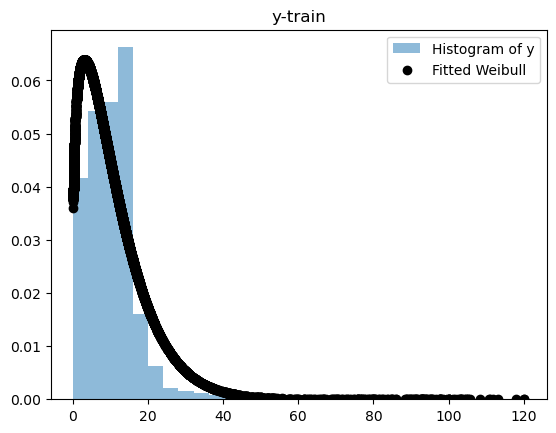

In [59]:
rv = sc_stats.weibull_min.fit(y_train)
print (rv)
plt.hist(y_train,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y_train, sc_stats.weibull_min.pdf(y_train,*rv),label="Fitted Weibull",color="black")
plt.title("y-train")
plt.legend()

In [60]:
x_train.shape

(18640, 45)

In [93]:
def results_weibull_model(c):
    k=1.2386219353578642
    weibull_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(350, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(300, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(300, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(250, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(250, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(200, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(200, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(200, kernel_initializer='normal', activation="leaky_relu"),
        loss_and_layers.DenseWeibullGamma(1),
    ])

    def weibullLoss(true, pred):
        return loss_and_layers.weibull_evidence_Regression(true, pred, k=k, coeff=c)

    # Compile and fit the model!
    weibull_model.compile(
        optimizer=tf.keras.optimizers.Adam(7e-4),
        loss=weibullLoss)
    weibull_model.fit(x_train, y_train, batch_size=160, epochs=340, verbose = 0)
    y_pred = weibull_model.predict(x_test);
    alpha,beta = y_pred[:,0],y_pred[:,1]
    return y_pred,weibull_model

In [82]:
from scipy.special import loggamma

In [95]:
results_wibull = {}
k=1.238
for c_i in np.logspace(-4,-2,20):
    results_wibull[c_i] = results_weibull_model(c_i)
    y_pred = results_wibull[c_i][0]
    alpha,beta = y_pred[:,0],y_pred[:,1]
    mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
    mu = np.exp(mean_pred_log)
    print (f"For c={c_i}, MSE = {mean_squared_error(y_test,mu)}")

146/146 [==============================] - 0s 2ms/step
For c=0.0001, MSE = 43.34069580378244
146/146 [==============================] - 0s 2ms/step
For c=0.00012742749857031334, MSE = 46.80232326594089
146/146 [==============================] - 0s 2ms/step
For c=0.0001623776739188721, MSE = 39.736316931305545
146/146 [==============================] - 0s 2ms/step
For c=0.00020691380811147902, MSE = 34.24854376158857
146/146 [==============================] - 0s 2ms/step
For c=0.00026366508987303583, MSE = 39.32421293849704
146/146 [==============================] - 0s 2ms/step
For c=0.0003359818286283781, MSE = 36.496179636133995
146/146 [==============================] - 1s 3ms/step
For c=0.00042813323987193956, MSE = 42.652786073050045
146/146 [==============================] - 0s 2ms/step
For c=0.000545559478116852, MSE = 28.295903932564514
146/146 [==============================] - 0s 2ms/step
For c=0.0006951927961775605, MSE = 35.452779486432064
146/146 [==========================

In [103]:
weibull_model = results_wibull[0.002335721469090121][1]

In [104]:
weibull_model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_616 (Dense)           (None, 1)                 46        
                                                                 
 dense_617 (Dense)           (None, 350)               700       
                                                                 
 dense_618 (Dense)           (None, 300)               105300    
                                                                 
 dense_619 (Dense)           (None, 300)               90300     
                                                                 
 dense_620 (Dense)           (None, 250)               75250     
                                                                 
 dense_621 (Dense)           (None, 250)               62750     
                                                                 
 dense_622 (Dense)           (None, 200)             

In [125]:
y_pred = weibull_model.predict(x_train)
alpha,beta = y_pred[:,0],y_pred[:,1]

mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
mu = np.exp(mean_pred_log)

var_term1 = (loggamma(1+ (2/k)) - loggamma(alpha) + loggamma(alpha-(2/k))\
                + (2/k)*np.log(beta))
var = np.exp(var_term1) - np.square(mu)

mean_squared_error(y_train,mu),var.mean()

583/583 [==============================] - 1s 2ms/step


(17.401779731769285, 252.10397)

In [126]:
y_pred = weibull_model.predict(x_test)
alpha,beta = y_pred[:,0],y_pred[:,1]

mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
mu = np.exp(mean_pred_log)

var_term1 = (loggamma(1+ (2/k)) - loggamma(alpha) + loggamma(alpha-(2/k))\
                + (2/k)*np.log(beta))
var = np.exp(var_term1) - np.square(mu)
mean_squared_error(y_test,mu),var.mean()

146/146 [==============================] - 0s 2ms/step


(16.78805032478009, 268.83987)

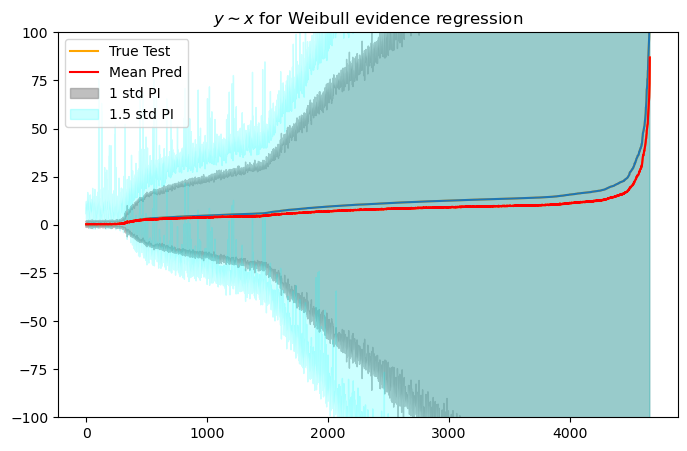

In [108]:
sort_idx = y_test.values.argsort()
mu_sorted = mu[sort_idx]
var = np.sqrt(beta / (v * (alpha - 1)))
var_sort = var[sort_idx]

#plot
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(y_test.values[sort_idx],label="True Test",alpha = 1, color="orange")
ax.plot(mu_sorted, zorder=3, label="Mean Pred",color="red")
plt.fill_between(x=range(len(mu[sort_idx])), y1=(mu_sorted - 1 * var_sort), \
                 y2=(mu_sorted + 1 * var_sort),\
                 label="1 std PI",color="grey",alpha=0.5)
plt.fill_between(x=range(len(mu[sort_idx])),
                 y1=(mu - 1.5 * var_sort), \
                 y2=(mu + 1.5 * var_sort),\
                 label="1.5 std PI",color="cyan",alpha=0.2)
ax.set_ylim(-100,100)
ax.legend()
ax.set_title("$y \sim x$ for Weibull evidence regression")

plt.plot(y_test.values[sort_idx],label="mean prediction")
plt.plot(mu_sorted,label="mean prediction")

In [91]:
results_wibull

{1e-05: (array([[ 108.99886, 1189.3091 ],
         [  99.63074, 1207.8002 ],
         [  87.76166, 1259.765  ],
         ...,
         [ 138.47328, 1076.7446 ],
         [  67.66775, 1457.0148 ],
         [ 699.6253 ,  181.88318]], dtype=float32),
  <keras.engine.sequential.Sequential at 0x16a04edf0>),
 1.623776739188721e-05: (array([[  80.64311,  914.4758 ],
         [  74.46046,  944.99475],
         [  66.32614,  994.0687 ],
         ...,
         [  98.662  ,  835.6394 ],
         [  50.28165, 1144.4451 ],
         [ 938.1384 ,  292.0598 ]], dtype=float32),
  <keras.engine.sequential.Sequential at 0x16e9dbe20>),
 2.6366508987303556e-05: (array([[nan, nan],
         [nan, nan],
         [nan, nan],
         ...,
         [nan, nan],
         [nan, nan],
         [nan, nan]], dtype=float32),
  <keras.engine.sequential.Sequential at 0x1698c59d0>)}

In [ ]:
edl_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(64, activation="softmax"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(20, activation="relu"),
        dense_layers.DenseNormalGamma(1),
    ])

def EvidentialRegressionLoss(true, pred):
        return dense_loss.EvidentialRegression(true, pred, coeff=25e-9)

# Compile and fit the model!
edl_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=EvidentialRegressionLoss)

edl_model.fit(x_train, y_train, batch_size=100, epochs=150)

In [ ]:
y_pred = edl_model.predict(x_test)
mu, v, alpha, beta = y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3]

In [ ]:
mean_squared_error(y_test,mu)*100/y_test.mean()

In [ ]:
alpha.min()

In [ ]:
var = np.sqrt(beta / (v * (alpha - 1)))
var.mean()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
plt.subplot(121)
plt.hist(y_train,bins=50)
plt.title("Distribnution of y-train")
plt.subplot(122)
plt.hist(mu,bins=100)
plt.title("Distribnution of y-pred(Normal)")

In [ ]:
plt.scatter(y_test,mu)
plt.xlabel("y-test")
plt.ylabel("y-pred from Benchmark")
plt.title("Benchmark evidence regression")

In [ ]:
k=1.244895
weibull_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=x_train.shape[1]),
        tf.keras.layers.Dense(400, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(400, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(400, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(350, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(350, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(300, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(300, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(250, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(250, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(200, kernel_initializer='normal', activation="relu"),
        tf.keras.layers.Dense(200, kernel_initializer='normal', activation="leaky_relu"),
        tf.keras.layers.Dense(200, kernel_initializer='normal', activation="leaky_relu"),
        loss_and_layers.DenseWeibullGamma(1),
    ])

def weibullLoss(true, pred):
        return loss_and_layers.weibull_evidence_Regression(true, pred, k=k, coeff=0.45e-15)

# Compile and fit the model!
weibull_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=weibullLoss)
    

In [ ]:
weibull_model.fit(x_train, y_train, batch_size=70, epochs=20)

In [ ]:
y_pred = weibull_model.predict(x_test)
alpha,beta = y_pred[:,0],y_pred[:,1]

In [ ]:
alpha

In [ ]:
beta

In [ ]:
from scipy.special import loggamma

In [ ]:
mean_pred_log = (loggamma(1+ (1/k)) - loggamma(alpha) + loggamma(alpha-(1/k))\
                + (1/k)*np.log(beta))
mu = np.exp(mean_pred_log)

var_term1 = (loggamma(1+ (2/k)) - loggamma(alpha) + loggamma(alpha-(2/k))\
                + (2/k)*np.log(beta))
var = np.exp(var_term1) - np.square(mu)
# var

In [ ]:
mean_squared_error(y_test,mu)*100/y_test.mean()

In [ ]:
from scipy.stats import invgamma
rv = invgamma(a=alpha,scale=beta*1.0)
theta = rv.rvs()
lambda_weibull = theta**(1/k)
y_pred_check = np.array([lambda_weibull*np.random.weibull(a=k) for i in range(100)]).mean(axis=0)

# plt.plot(x_test,y_test,label="y_test")
plt.scatter(y_test,y_pred_check,color="orange",label="mean pred from sampling")
plt.xlabel("y-test")
plt.ylabel("y-pred from Benchmark")
plt.title("Weibull evidence regression")
plt.legend()

In [ ]:
y_pred_check,mu

In [ ]:
plt.scatter(y_test,mu,color="orange",label="mean pred from analytical")

In [ ]:
fig,ax=plt.subplots(figsize=(18,6))
plt.subplot(131)
plt.hist(y_train,bins=50,density=True)
plt.title("Distribnution of y-train")
plt.subplot(132)
plt.hist(edl_model.predict(x_test)[:,0],bins=50,density=True)
plt.title("Distribnution of y-pred (Normal)")
plt.subplot(133)
plt.hist(mu,bins=50,density=True)
plt.title("Distribnution of y-pred (Weibull)")